Team LTTT

    |STT| Student Name         | Student ID |
    |1  | Võ Thị Khánh Linh    | 21280070  |
    |2  | Lê Quang Trung       | 21280113  |
    |3  | Nguyễn Nhật Minh Thư | 21280112  |
    |4  | Nguyễn Đặng Anh Thư  | 21280111  |

# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [ ]:
!pip install scikit-learn-intelex -q --progress-bar off

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.utils.class_weight import compute_class_weight
from skimage.feature import hog
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Access and Visualize the dataset

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
## load dataset here
df = pd.read_csv("/content/drive/MyDrive/NMMH-LTTT/data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


<ipython-input-8-178297789c64>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='emotion', y='number', data=emotion_counts, palette=colors.values())


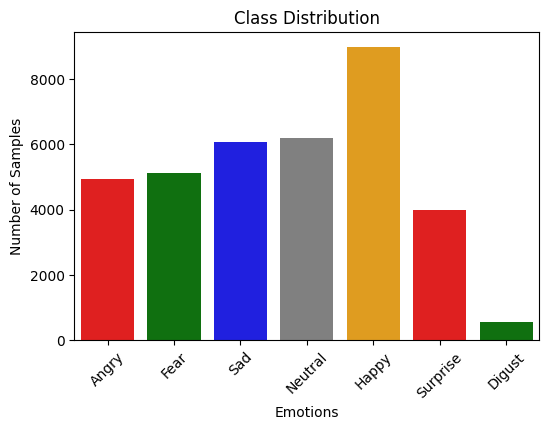

In [ ]:
colors = {
    'Angry': 'red',
    'Happy': 'green',
    'Sad': 'blue',
    'Neutral': 'gray',
    'Surprise': 'orange'
}

# Plotting a bar graph of the class distributions
plt.figure(figsize=(6, 4))
sns.barplot(x='emotion', y='number', data=emotion_counts, palette=colors.values())
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Emotions')
plt.xticks(rotation=45)
plt.show()

Based on the class distribution plot, we can observe that the dataset is imbalanced, with the "Happy" emotion having the highest number of samples and the "Disgust" emotion having significantly fewer samples compared to the other emotion labels. The remaining four emotions ("Angry," "Fear," "Sad," "Neutral") have relatively similar distributions and can be grouped into two pairs: "Angry" and "Fear," and "Sad" and "Neutral."

In [ ]:
## parsing data here
images, labels = parse_data(df)

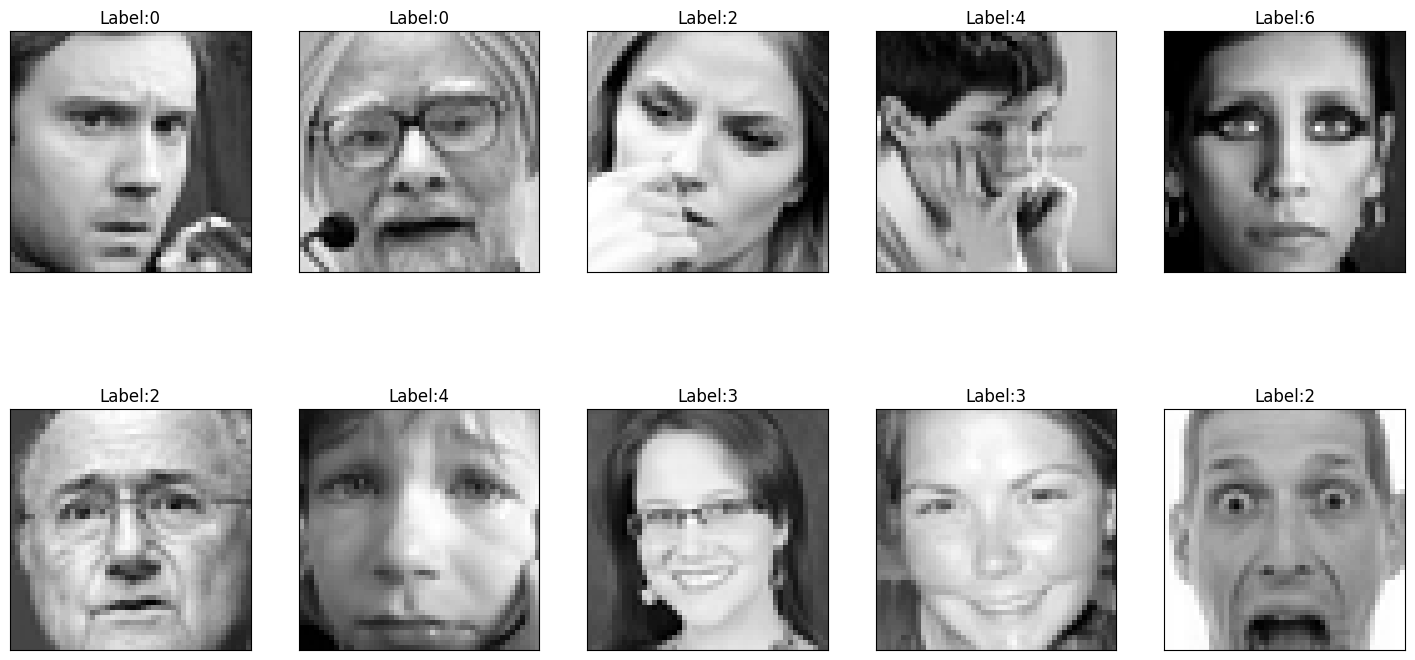

In [ ]:
## showing images here
show_img(images, labels)

### Split Dataset

We performed a train-test split to ensure that during the use of PCA for data transformation, the PCA model is only fitted on the training set and then applied to the test set. This approach prevents data leakage and ensures that the test data remains unseen during the training process.

In [ ]:
# Splitting data into train/test subsets here
# Train:Test = 0.8:0.2
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
# Display Shape of Train/Test/Valid Set
print(f"Images Training Shape: {X_train.shape}; \tLabels Training Shape: {y_train.shape}")
print(f"Images Validation Shape: {X_test.shape}; \tLabels Validation Shape: {y_test.shape}")

Images Training Shape: (28709, 48, 48); 	Labels Training Shape: (28709,)
Images Validation Shape: (7178, 48, 48); 	Labels Validation Shape: (7178,)


### Class Weight

One effective technique for addressing class imbalance is the strategic use of class weights. Class weights assign higher weights to the minority class, allowing the model to pay more attention to its patterns and reducing bias towards the majority class.

In [ ]:
# Calculating class weights
unique_classes = np.unique(y_train)
class_counts = list(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=class_counts)
class_weights_dict = dict(zip(unique_classes, class_weights))
# Printing class weights
print("Class Weights Dictionary:")
for key, value in class_weights_dict.items():
    print(f"Class {key}: {value}")

Class Weights Dictionary:
Class 0: 1.0335901497695852
Class 1: 9.216372391653291
Class 2: 1.0057100819729559
Class 3: 0.5677305806043348
Class 4: 0.8426722240159676
Class 5: 1.2788542919506436
Class 6: 0.8335946573751452


Class weights were calculated solely based on the training data (y_train) to ensure that no information from the test set was disclosed or used during the training process.

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [ ]:
from sklearn.decomposition import PCA

<ipython-input-40-865b52d84404>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(projected[labels == label, 0], projected[labels == label, 1], label=label, cmap='nipy_spectral')


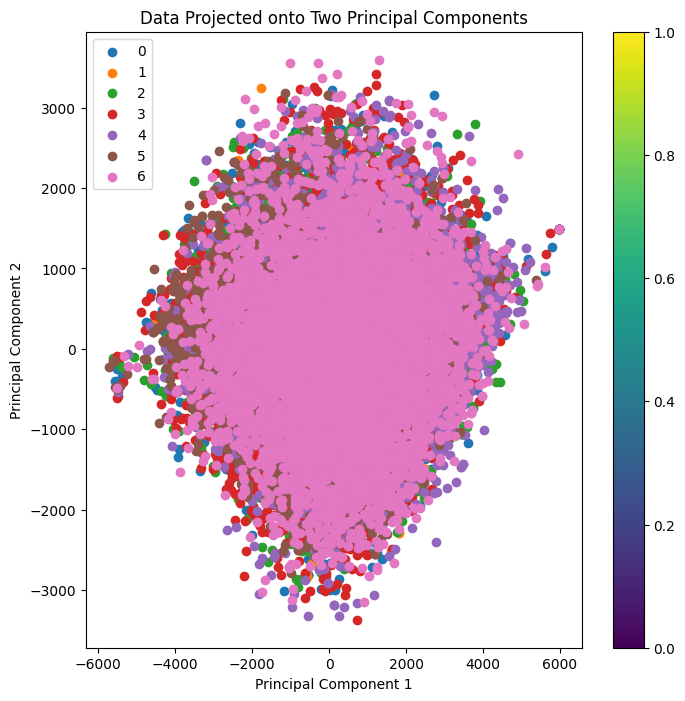

In [ ]:
def visualize_pca(images: np.ndarray, labels: np.ndarray):
    """
    Perform PCA and visualize data projected onto two principal components
    """
    # Flatten images
    flattened_images = images.reshape(len(images), -1)

    # Perform PCA
    pca = PCA(n_components=2)
    projected = pca.fit_transform(flattened_images)

    # Plot projected data
    plt.figure(figsize=(8, 8))
    for label in np.unique(labels):
        plt.scatter(projected[labels == label, 0], projected[labels == label, 1], label=label, cmap='nipy_spectral')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.title("Data Projected onto Two Principal Components")
    plt.colorbar()

    plt.show()

visualize_pca(images, labels)
plt.show()

Based on the presented image, it can be observed that the data has been projected onto two principal components.  The data points are distributed in a complex pattern in the two-dimensional space. There are some distinct groups of data points, with closely colored points forming clusters. However, there are also scattered data points that do not clearly belong to any specific group.

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

Since the determination of the number of components to retain is part of the training process, we fitted the PCA only on the training data (x_train).

In [ ]:
# Flatten the images for PCA
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# Apply PCA to the training set
pca = PCA()
X_train_pca = pca.fit_transform(X_train_flattened)

# Apply the same PCA transformation to the test set
X_test_pca = pca.transform(X_test_flattened)

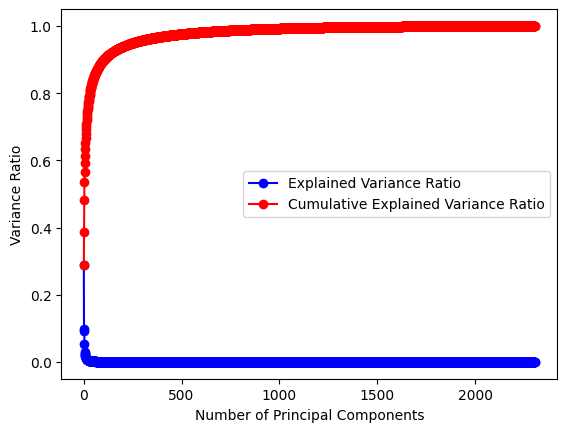

In [ ]:
# variance ratio explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
# compute the cumulative sum of the explained variance ratios.
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# plot the explained variance ratio and cumulative explained variance against the number of principal components to visualize the information captured by each component
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'b-o', label='Explained Variance Ratio')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'r-o', label='Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Ratio')
plt.legend()
plt.show()

In [ ]:
# set a a list of thresholds (0.90, 0.95, 0.99) for the cumulative explained variance ratio  to determine the number of principal components needed to reach specific cumulative variance levels
thresholds = [0.90, 0.95, 0.99]
num_components = []

for threshold in thresholds:
    num_components.append(np.argmax(cumulative_variance_ratio >= threshold) + 1)

for i, threshold in enumerate(thresholds):
    print("Number of Principal Components to reach {:.2f}% cumulative variance: {}".format(threshold * 100, num_components[i]))

Number of Principal Components to reach 90.00% cumulative variance: 104
Number of Principal Components to reach 95.00% cumulative variance: 255
Number of Principal Components to reach 99.00% cumulative variance: 883


It is evident that the number of principal components needed to reach 90% and 95% cumulative variance is more reasonable to choose compared to the number of principal components needed to reach 99% cumulative variance. The reason is that the latter requires almost four times the number of components compared to the previous one (the number needed for 95% cumulative variance). The trade-off of such a large gap to achieve an additional 0.4% cumulative variance is unnecessary.

Furthermore, after applying logistic regression, Random Forest, SVM, and MLP algorithms to the data using PCA with 90% and 95% of the principal components, it was observed that using 90% of the principal components produced better results. Therefore, our team decided to select 104 principal components to apply PCA based on 90% cumulative variance.

We think it is essential to consider both the amount of variance retained and the computational cost or complexity when choosing the number of principal components. In this case, a balance was struck by selecting a reasonable number of components that still captured a substantial portion of the variance.

In [ ]:
# Apply PCA to the training set
pca = PCA(n_components=104)  # Retain 90% of the variance
X_train_pca = pca.fit_transform(X_train_flattened)

# Apply the same PCA transformation to the test set
X_test_pca = pca.transform(X_test_flattened)

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


We experimented with three different representations of the data:

* Original Data: The raw dataset as it is.

* PCA Transformed Data: After applying PCA transformation, retaining 104 principal components.

* HOG Extracted Features: Using the Histogram of Oriented Gradients (HOG) algorithm to extract features from images.

These representations were used across our models: Logistic Regression, Random Forest, SVM, and MLP, to evaluate their performance in classification tasks.




### With Original Data

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

#### Logistic Classifier

In [ ]:
# Logistic Regression
log_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty=None)

# Fit the model and train
log_regression.fit(X_train, y_train)

# Let us measure performance
score = log_regression.score(X_test, y_test)
print("The accuracy score is:", score*100)

The accuracy score is: 35.34410699359153


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Make predictions on entire test data
y_prediction = log_regression.predict(X_test)
#Create a confusion matrix
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.26      0.17      0.20       733
           1       0.00      0.00      0.00        87
           2       0.26      0.15      0.19       804
           3       0.43      0.67      0.53      1379
           4       0.25      0.20      0.22       887
           5       0.41      0.41      0.41       587
           6       0.33      0.36      0.34       906

    accuracy                           0.36      5383
   macro avg       0.28      0.28      0.27      5383
weighted avg       0.33      0.36      0.33      5383



#### Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators = 100)

#Fit the model and train
rfc.fit(X_train, y_train)
#Let us measure performance
score = rfc.score(X_test, y_test)
print("The accuracy score is:", score*100)

The accuracy score is: 45.94092513468326


#### SVM

In [ ]:
svm = SVC(gamma='auto')

#Fit the model and train
svm.fit(X_train_flatten, y_train)
#Let us measure performance
score = svm.score(X_test_flatten, y_test)
print("The accuracy score is:", score*100)

The accuracy score is: 31.450863830577745


#### MLP

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(10,),
                    max_iter = 300,
                    activation = 'relu',
                    solver = 'adam')
#Fit the model and train
mlp.fit(X_train, y_train)
#Let us measure performance
score = mlp.score(X_test, y_test)
print("The accuracy score is:", score*100)

The accuracy score is: 25.617685305591674


### With Transformed Data

Transformed data: The data projected onto the optimal number of principal components identified earlier (104 components).

#### Logistic Classifier

In [ ]:
# Logistic Classifier
log_regression = LogisticRegression(multi_class='ovr', solver='liblinear')

# Fit the model and train
log_regression.fit(X_train_pca, y_train)
# Let us measure performance
score = log_regression.score(X_test_pca, y_test)
print("The accuracy score is:", score*100)

The accuracy score is: 36.639732516021176


#### Random Forest

In [ ]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100)

# Fit the model and train
rfc.fit(X_train_pca, y_train)
# Let us measure performance
score = rfc.score(X_test_pca, y_test)
print("The accuracy score is:", score*100)

The accuracy score is: 41.79437169127891


#### SVM

In [ ]:
# Support Vector Machine
svm = SVC(gamma='auto')

# Fit the model and train
svm.fit(X_train_pca, y_train)
# Let us measure performance
score = svm.score(X_test_pca, y_test)
print("The accuracy score is:", score*100)

The accuracy score is: 27.249930342713846


#### MLP

In [ ]:
# Multi Layer Perceptron
mlp = MLPClassifier(hidden_layer_sizes=(2, ), activation="logistic", learning_rate="adaptive", batch_size=32, max_iter=200)

#Fit the model and train
mlp.fit(X_train_pca, y_train)
#Let us measure performance
score = mlp.score(X_test_pca, y_test)
print("The accuracy score is:", score*100)

The accuracy score is: 31.373641682920034


### With HOG Algorithm

We utilized the Histogram of Oriented Gradients (HOG) algorithm to extract features from images. HOG is effective in representing the main contours of the face by capturing the direction and magnitude of gradients through vectors in each cell.

#### Apply HOG

In [ ]:
from skimage.feature import hog
from tqdm import tqdm

# Function to preprocess images using HOG with support for grayscale and color/multichannel images
def preprocess_with_hog(images):
    hog_features = []
    # For visualize
    hog_images = []
    for image in tqdm(images):
        # Calculate HOG features and visualize HOG image
        features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys',  visualize=True)
        hog_features.append(features)
        hog_images.append(hog_image)
    hog_features = np.array(hog_features)
    return hog_features, hog_images

In [ ]:
train_hog_features, train_hog_images = preprocess_with_hog(X_train)
test_hog_features, _ = preprocess_with_hog(X_test)

print("\n", train_hog_features.shape)
print(test_hog_features.shape)

100%|██████████| 7178/7178 [01:23<00:00, 86.04it/s] 


 (28709, 900)
(7178, 900)


#### Logistic Classifier

In [ ]:
# Logistic Classifier
log_regression = LogisticRegression(class_weight=class_weights_dict, multi_class='multinomial', solver='saga', penalty=None)

# Fit the model and train
log_regression.fit(train_hog_features, y_train)
# Let us measure performance
score = log_regression.score(test_hog_features, y_test)
print("The accuracy score is:", score*100)

The accuracy score is: 41.083867372527166


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Random Forest

In [ ]:
# Model Random Forest
rfc = RandomForestClassifier(class_weight=class_weights_dict, n_estimators = 100)

# Fit the model and train
rfc.fit(train_hog_features, y_train)

# Let us measure performance
score = rfc.score(test_hog_features, y_test)
print("The accuracy score is:", score*100)

The accuracy score is: 44.69211479520758


#### SVM

In [ ]:
# Model Support Vector Machine
svm = SVC(class_weight=class_weights_dict, C=0.1, degree=6, kernel= 'poly')

# Fit the model and train
svm.fit(train_hog_features, y_train)

# Let us measure performance
score = svm.score(test_hog_features, y_test)
print("The accuracy score is:", score*100)

The accuracy score is: 56.436333240456946


#### MLP

In [ ]:
# Model Multi Layer Perceptron
mlp = MLPClassifier(hidden_layer_sizes=(100, ), activation="logistic", learning_rate="adaptive", batch_size=64, max_iter=200)

# Fit the model and train
mlp.fit(train_hog_features, y_train)

# Let us measure performance
score = mlp.score(test_hog_features, y_test)
print("The accuracy score is:", score*100)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


The accuracy score is: 46.96294232376707


### Hyperparameters Tuning

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)


#### Logistic Classifier

In [ ]:
# Defining parameters
param_grid = {
    'penalty': ['l2', None],
    'C': [0.1, 1],
}

# Creating an Logistic classifier
lr = LogisticRegression(class_weight=class_weights_dict, multi_class='multinomial',solver = 'saga', max_iter = 200)

# Performing gridsearch
gscv = GridSearchCV(lr, param_grid, cv=5, scoring='f1_weighted', verbose=3)
gscv.fit(train_hog_features, y_train)

# Printing best scores and parameters
print("Best cross-validation score: {:.2f}".format(gscv.best_score_))
print("Best parameters found: ", gscv.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .................C=0.1, penalty=l2;, score=0.426 total time= 3.4min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .................C=0.1, penalty=l2;, score=0.398 total time= 3.4min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .................C=0.1, penalty=l2;, score=0.389 total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .................C=0.1, penalty=l2;, score=0.311 total time= 3.2min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END .................C=0.1, penalty=l2;, score=0.404 total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...............C=0.1, penalty=None;, score=0.407 total time= 3.2min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ...............C=0.1, penalty=None;, score=0.383 total time= 3.2min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ...............C=0.1, penalty=None;, score=0.388 total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...............C=0.1, penalty=None;, score=0.367 total time= 3.4min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...............C=0.1, penalty=None;, score=0.414 total time= 3.2min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...................C=1, penalty=l2;, score=0.398 total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...................C=1, penalty=l2;, score=0.394 total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...................C=1, penalty=l2;, score=0.418 total time= 3.2min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...................C=1, penalty=l2;, score=0.410 total time= 3.6min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...................C=1, penalty=l2;, score=0.397 total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .................C=1, penalty=None;, score=0.343 total time= 3.2min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .................C=1, penalty=None;, score=0.387 total time= 3.2min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .................C=1, penalty=None;, score=0.395 total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .................C=1, penalty=None;, score=0.287 total time= 3.2min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .................C=1, penalty=None;, score=0.394 total time= 3.2min
Best cross-validation score: 0.40
Best parameters found:  {'C': 1, 'penalty': 'l2'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameters: {'C': 1, 'penalty': 'l2'}

In [ ]:
y_test_pred_lr = gscv.predict(test_hog_features)
print(classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.30      0.32      0.31       985
           1       0.11      0.51      0.18       102
           2       0.31      0.20      0.24      1043
           3       0.62      0.63      0.62      1765
           4       0.31      0.35      0.33      1210
           5       0.51      0.61      0.56       795
           6       0.46      0.32      0.38      1278

    accuracy                           0.42      7178
   macro avg       0.38      0.42      0.37      7178
weighted avg       0.43      0.42      0.42      7178



#### Random Forest

In [ ]:
# Defining parameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Creating an SVC classifier
rfc = RandomForestClassifier(class_weight=class_weights_dict, n_estimators = 100)

# Performing gridsearch
gscv = GridSearchCV(rfc, param_grid, cv=5, scoring='f1_weighted', verbose=3)
gscv.fit(X_train_flattened, y_train)

# Printing best scores and parameters
print("Best cross-validation score: {:.2f}".format(gscv.best_score_))
print("Best parameters found: ", gscv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END criterion=gini, min_samples_leaf=1, min_samples_split=2;, score=0.414 total time= 3.5min
[CV 2/5] END criterion=gini, min_samples_leaf=1, min_samples_split=2;, score=0.411 total time= 3.1min
[CV 3/5] END criterion=gini, min_samples_leaf=1, min_samples_split=2;, score=0.406 total time= 3.1min
[CV 4/5] END criterion=gini, min_samples_leaf=1, min_samples_split=2;, score=0.410 total time= 3.3min
[CV 5/5] END criterion=gini, min_samples_leaf=1, min_samples_split=2;, score=0.411 total time= 3.1min
[CV 1/5] END criterion=gini, min_samples_leaf=1, min_samples_split=5;, score=0.422 total time= 3.0min
[CV 2/5] END criterion=gini, min_samples_leaf=1, min_samples_split=5;, score=0.413 total time= 3.0min
[CV 3/5] END criterion=gini, min_samples_leaf=1, min_samples_split=5;, score=0.410 total time= 3.1min
[CV 4/5] END criterion=gini, min_samples_leaf=1, min_samples_split=5;, score=0.415 total time= 2.9min
[CV 5/5] END criterion

Best parameters found:  {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5}

In [ ]:
y_test_pred_rfc = gscv.predict(X_test_flattened)
print(classification_report(y_test, y_test_pred_rfc))

              precision    recall  f1-score   support

           0       0.51      0.24      0.33       985
           1       0.94      0.32      0.48       102
           2       0.50      0.29      0.36      1043
           3       0.43      0.75      0.55      1765
           4       0.37      0.37      0.37      1210
           5       0.65      0.59      0.62       795
           6       0.46      0.39      0.42      1278

    accuracy                           0.46      7178
   macro avg       0.55      0.42      0.45      7178
weighted avg       0.48      0.46      0.45      7178



#### SVM

In [ ]:
# Defining parameters
param_grid = {
    'C': [0.1, 1],
    'kernel': ['poly'],
    'degree': [5, 6],
}

# Creating an SVC classifier
svc = SVC(class_weight=class_weights_dict)

# Performing gridsearch
gscv = GridSearchCV(svc, param_grid, cv=5, scoring='f1_weighted', verbose=3)
gscv.fit(train_hog_features, y_train)

# Printing best scores and parameters
print("Best cross-validation score: {:.2f}".format(gscv.best_score_))
print("Best parameters found: ", gscv.best_params_)

INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Fitting 5 folds for each of 4 candidates, totalling 20 fits


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 1/5] END ......C=0.1, degree=5, kernel=poly;, score=0.541 total time= 2.2min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 2/5] END ......C=0.1, degree=5, kernel=poly;, score=0.543 total time= 2.2min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 3/5] END ......C=0.1, degree=5, kernel=poly;, score=0.544 total time= 2.2min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 4/5] END ......C=0.1, degree=5, kernel=poly;, score=0.543 total time= 2.2min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 5/5] END ......C=0.1, degree=5, kernel=poly;, score=0.536 total time= 2.2min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 1/5] END ......C=0.1, degree=6, kernel=poly;, score=0.550 total time= 2.1min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 2/5] END ......C=0.1, degree=6, kernel=poly;, score=0.547 total time= 2.1min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 3/5] END ......C=0.1, degree=6, kernel=poly;, score=0.549 total time= 2.1min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 4/5] END ......C=0.1, degree=6, kernel=poly;, score=0.542 total time= 2.1min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 5/5] END ......C=0.1, degree=6, kernel=poly;, score=0.539 total time= 2.1min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 1/5] END ........C=1, degree=5, kernel=poly;, score=0.541 total time= 2.2min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 2/5] END ........C=1, degree=5, kernel=poly;, score=0.543 total time= 2.2min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 3/5] END ........C=1, degree=5, kernel=poly;, score=0.543 total time= 2.2min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 4/5] END ........C=1, degree=5, kernel=poly;, score=0.540 total time= 2.2min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 5/5] END ........C=1, degree=5, kernel=poly;, score=0.537 total time= 2.2min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 1/5] END ........C=1, degree=6, kernel=poly;, score=0.546 total time= 2.1min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 2/5] END ........C=1, degree=6, kernel=poly;, score=0.547 total time= 2.1min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 3/5] END ........C=1, degree=6, kernel=poly;, score=0.547 total time= 2.1min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 4/5] END ........C=1, degree=6, kernel=poly;, score=0.541 total time= 2.1min


INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 5/5] END ........C=1, degree=6, kernel=poly;, score=0.538 total time= 2.1min
Best cross-validation score: 0.55
Best parameters found:  {'C': 0.1, 'degree': 6, 'kernel': 'poly'}


#### MLP

In [ ]:
# Defining parameters
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['relu', 'logistic'],
    'learning_rate': ['adaptive'],
    'max_iter': [100, 200]
}

# Creating an MLP classifier
mlp = MLPClassifier()

# Performing gridsearch
gscv = GridSearchCV(mlp, param_grid, cv=5, scoring='f1_weighted', verbose=3)
gscv.fit(train_hog_features, y_train)

# Printing best scores and parameters
print("Best cross-validation score: {:.2f}".format(gscv.best_score_))
print("Best parameters found: ", gscv.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.430 total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.447 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.437 total time= 2.3min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.442 total time= 2.3min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.444 total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.429 total time= 4.8min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.431 total time= 4.7min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.435 total time= 5.0min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.428 total time= 5.1min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.425 total time= 5.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.445 total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.453 total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.439 total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.445 total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.446 total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.431 total time= 6.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.431 total time= 5.9min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.419 total time= 5.9min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.425 total time= 6.3min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.429 total time= 6.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.462 total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.461 total time= 2.7min


In [ ]:
# Defining parameters
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['relu', 'logistic'],
    'learning_rate': ['adaptive'],
    'max_iter': [100, 200]
}

# Creating an MLP classifier
mlp = MLPClassifier(class_weight=class_weights_dict)

# Performing gridsearch
gscv = GridSearchCV(mlp, param_grid, cv=5, scoring='f1_weighted', verbose=3)
gscv.fit(train_hog_features, y_train)

# Printing best scores and parameters
print("Best cross-validation score: {:.2f}".format(gscv.best_score_))
print("Best parameters found: ", gscv.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV 1/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.447 total time=  24.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.438 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.441 total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.424 total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.443 total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.432 total time= 5.3min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.426 total time= 5.0min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.433 total time= 5.8min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.418 total time= 5.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.410 total time= 5.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.445 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.439 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.439 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.438 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.440 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.433 total time= 6.3min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.435 total time= 5.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.439 total time= 6.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.425 total time= 5.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.429 total time= 5.1min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.469 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.446 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.463 total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.462 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.475 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200;, score=0.449 total time= 6.0min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200;, score=0.449 total time= 5.1min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200;, score=0.448 total time= 5.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200;, score=0.451 total time= 5.0min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200;, score=0.451 total time= 4.9min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.455 total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.458 total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.448 total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.453 total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=100;, score=0.468 total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.448 total time= 4.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.451 total time= 4.3min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.446 total time= 4.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.454 total time= 4.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200;, score=0.445 total time= 4.6min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.443 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.469 total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.460 total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.463 total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100;, score=0.460 total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.443 total time= 5.3min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.449 total time= 5.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.459 total time= 5.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.453 total time= 5.0min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200;, score=0.457 total time= 5.1min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.471 total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.474 total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.465 total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.477 total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=100;, score=0.472 total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200;, score=0.478 total time= 5.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200;, score=0.480 total time= 5.3min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200;, score=0.488 total time= 5.3min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200;, score=0.481 total time= 5.2min


## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
def calculate_performance(y_true, y_pred, average='weighted'):
    """
    :param y_true: ground truth values
    :param y_pred: predictions
    :return:
    """
    print("Precision: {:.4f}".format(precision_score(y_true , y_pred, average=average)))
    print("Recall: {:.4f}".format(recall_score(y_true , y_pred, average=average)))
    print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))
    print("F1: {:.4f}".format(f1_score(y_true , y_pred, average=average)))
#     print("Confusion matrix: \n", confusion_matrix(y_true , y_pred, normalize='true'))
    print("Classification report: \n", classification_report(y_true , y_pred))

    main_score = f1_score(y_true , y_pred, average=average)
    return main_score

### Best case of each classification models

In [ ]:
# Best case of Logistic Classifier is: With HOG Algorithm
log_classifier = LogisticRegression(class_weight=class_weights_dict, multi_class='multinomial', C=1, penalty='l2')

# Fit the model and train
log_classifier.fit(train_hog_features, y_train)

# Prediction
y_test_pred_lc = log_classifier.predict(test_hog_features)

In [ ]:
# Best case of Random Forest is: With original data
rfc = RandomForestClassifier(criterion='gini', min_samples_leaf=2, min_samples_split=5, n_estimators = 100)

# Fit the model and train
rfc.fit(X_train_flattened, y_train)

# Prediction
y_test_pred_rfc = rfc.predict(X_test_flattened)

In [ ]:
# Best case of SVM is: With HOG Algorithm
svm = SVC(class_weight=class_weights_dict, C=0.1, degree=6, kernel= 'poly')

# Fit the model and train
svm.fit(train_hog_features, y_train)

# Prediction
y_test_pred_svm = svm.predict(test_hog_features)

In [ ]:
# Best case of MLP is: With HOG Algorithm
mlp = MLPClassifier(hidden_layer_sizes=(100, ), activation="logistic", learning_rate="adaptive", batch_size=64, max_iter=200)

# Fit the model and train
mlp.fit(train_hog_features, y_train)

# Prediction
y_test_pred_mlp = mlp.predict(test_hog_features)

The best model is **Support Vector Machine** with data after applying **HOG algorithm**.

**Reason:** The combination of SVC with HOG features leverages the strengths of both the feature extraction technique and the classification algorithm, resulting in a highly effective model for emotion recognition from facial images

### Performance

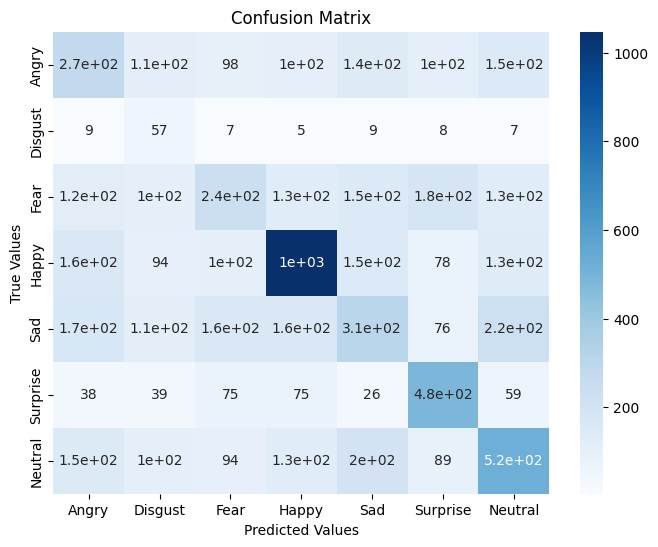

Precision: 0.4252
Recall: 0.4081
Accuracy: 0.4081
F1: 0.4116
Classification report: 
               precision    recall  f1-score   support

           0       0.30      0.28      0.29       985
           1       0.09      0.56      0.16       102
           2       0.31      0.23      0.26      1043
           3       0.64      0.59      0.61      1765
           4       0.32      0.26      0.28      1210
           5       0.47      0.61      0.53       795
           6       0.43      0.41      0.42      1278

    accuracy                           0.41      7178
   macro avg       0.36      0.42      0.36      7178
weighted avg       0.43      0.41      0.41      7178

Main score (F1): 0.4116


In [ ]:
# Logistic Classifier
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
lc_cm = confusion_matrix(y_test, y_test_pred_lc)
# Plotting normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(lc_cm, cmap='Blues', annot=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.show()
print("Main score (F1): {:.4f}".format(calculate_performance(y_test, y_test_pred_lc)))

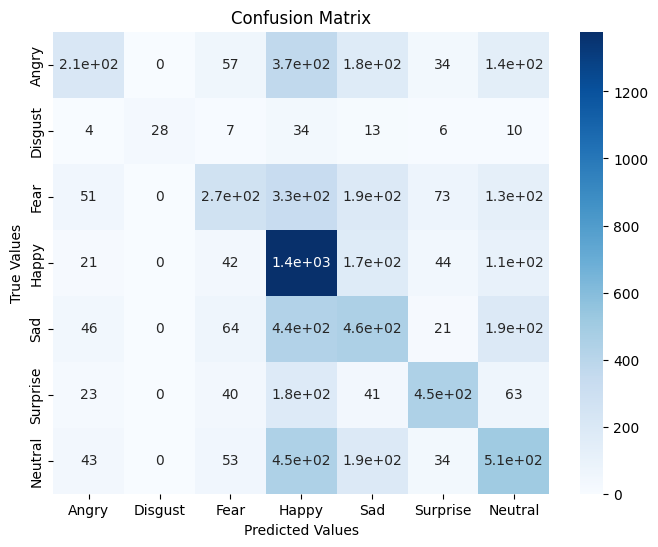

Precision: 0.4844
Recall: 0.4606
Accuracy: 0.4606
F1: 0.4417
Classification report: 
               precision    recall  f1-score   support

           0       0.53      0.21      0.30       985
           1       1.00      0.27      0.43       102
           2       0.51      0.26      0.35      1043
           3       0.43      0.78      0.56      1765
           4       0.37      0.38      0.37      1210
           5       0.68      0.57      0.62       795
           6       0.45      0.40      0.42      1278

    accuracy                           0.46      7178
   macro avg       0.57      0.41      0.44      7178
weighted avg       0.48      0.46      0.44      7178

Main score (F1): 0.4417


In [ ]:
# Random Forest Classifider
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
rfc_cm = confusion_matrix(y_test, y_test_pred_rfc)
# Plotting normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rfc_cm, cmap='Blues', annot=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.show()
print("Main score (F1): {:.4f}".format(calculate_performance(y_test, y_test_pred_rfc)))

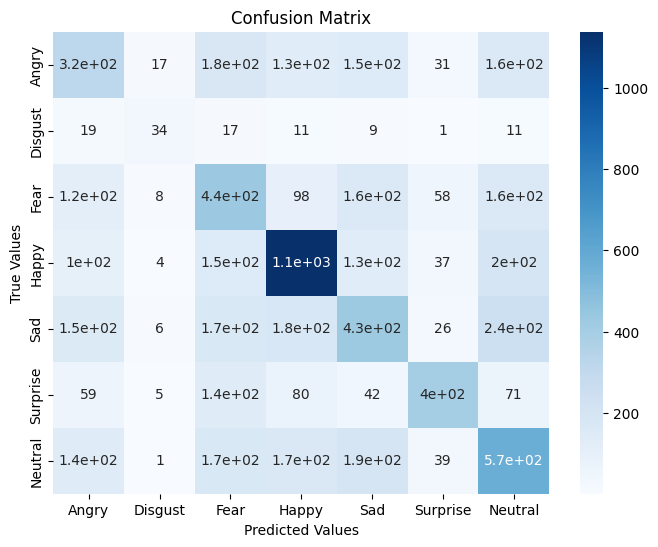

Precision: 0.4710
Recall: 0.4635
Accuracy: 0.4635
F1: 0.4648
Classification report: 
               precision    recall  f1-score   support

           0       0.35      0.32      0.34       985
           1       0.45      0.33      0.38       102
           2       0.35      0.42      0.38      1043
           3       0.63      0.64      0.64      1765
           4       0.38      0.35      0.37      1210
           5       0.68      0.51      0.58       795
           6       0.40      0.45      0.42      1278

    accuracy                           0.46      7178
   macro avg       0.46      0.43      0.44      7178
weighted avg       0.47      0.46      0.46      7178

Main score (F1): 0.4648


In [ ]:
# Multi Layer Perceptron
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
mlp_cm = confusion_matrix(y_test, y_test_pred_mlp)
# Plotting normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_cm, cmap='Blues', annot=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.show()
print("Main score (F1): {:.4f}".format(calculate_performance(y_test, y_test_pred_mlp)))

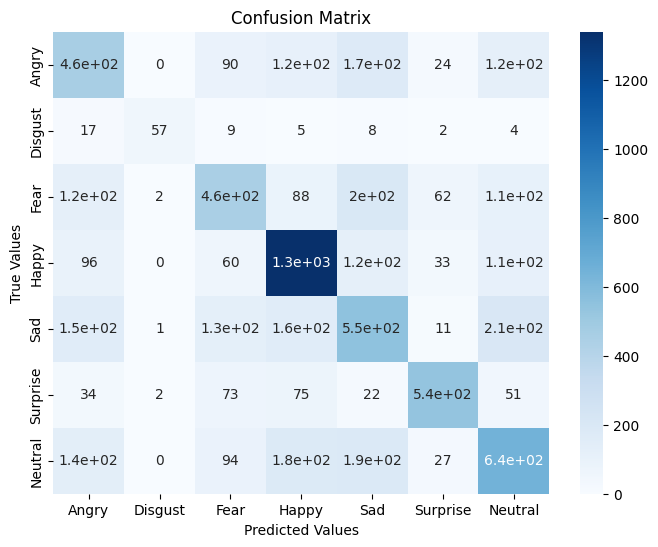

Precision: 0.5663
Recall: 0.5644
Accuracy: 0.5644
F1: 0.5635
Classification report: 
               precision    recall  f1-score   support

           0       0.45      0.47      0.46       985
           1       0.92      0.56      0.70       102
           2       0.50      0.44      0.47      1043
           3       0.68      0.76      0.72      1765
           4       0.44      0.46      0.45      1210
           5       0.77      0.68      0.72       795
           6       0.52      0.50      0.51      1278

    accuracy                           0.56      7178
   macro avg       0.61      0.55      0.57      7178
weighted avg       0.57      0.56      0.56      7178

Main score (F1): 0.5635


In [ ]:
# Support Vector Machine
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
svc_cm = confusion_matrix(y_test, y_test_pred_svc)
# Plotting normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(svc_cm, cmap='Blues', annot=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.show()
print("Main score (F1): {:.4f}".format(calculate_performance(y_test, y_test_pred_svc)))

Given that our primary evaluation metric is the F1 score, we identified the best and worst performing classes based on this metric:

1. Best Recognized Classes:

- Happy: This class achieved one of the highest F1 scores, indicating that the models were effective in accurately identifying happy expressions. The distinctive features of a happy face, such as smiling, likely contributed to this strong performance.
- Surprise: Similarly, the class for Surprise also received a high F1 score. The unique facial expressions associated with surprise, which often include widened eyes and raised eyebrows, made it easier for the models to distinguish this emotion.
2. Worst Recognized Class:

 Sad: The class for Sad achieved the lowest F1 score, suggesting that the models struggled to accurately identify sad expressions. This could be due to the subtle nature of sad facial expressions, which might overlap with other emotions such as Neutral or Angry, leading to higher misclassification rates.
These observations highlight the variability in model performance across different classes and emphasize the need for targeted improvements in recognizing emotions that are harder to distinguish.